In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import timm
from PIL import Image
import os
import numpy as np



In [3]:
import os

train_dir = '/content/drive/MyDrive/emotion detection images/train'
test_dir = '/content/drive/MyDrive/emotion detection images/test'

# Print categories and the number of images in each category
train_categories = os.listdir(train_dir)
test_categories = os.listdir(test_dir)

print("Training Categories:", train_categories)
for category in train_categories:
    print(f"Number of images in {category} (train):", len(os.listdir(os.path.join(train_dir, category))))

print("Testing Categories:", test_categories)
for category in test_categories:
    print(f"Number of images in {category} (test):", len(os.listdir(os.path.join(test_dir, category))))


Training Categories: ['angry', 'disgusted', 'fearful', 'happy', 'surprised', 'sad', 'neutral']
Number of images in angry (train): 4015
Number of images in disgusted (train): 436
Number of images in fearful (train): 4117
Number of images in happy (train): 7225
Number of images in surprised (train): 3171
Number of images in sad (train): 4850
Number of images in neutral (train): 4975
Testing Categories: ['fearful', 'disgusted', 'happy', 'angry', 'sad', 'surprised', 'neutral']
Number of images in fearful (test): 1024
Number of images in disgusted (test): 111
Number of images in happy (test): 1774
Number of images in angry (test): 958
Number of images in sad (test): 1247
Number of images in surprised (test): 831
Number of images in neutral (test): 1233


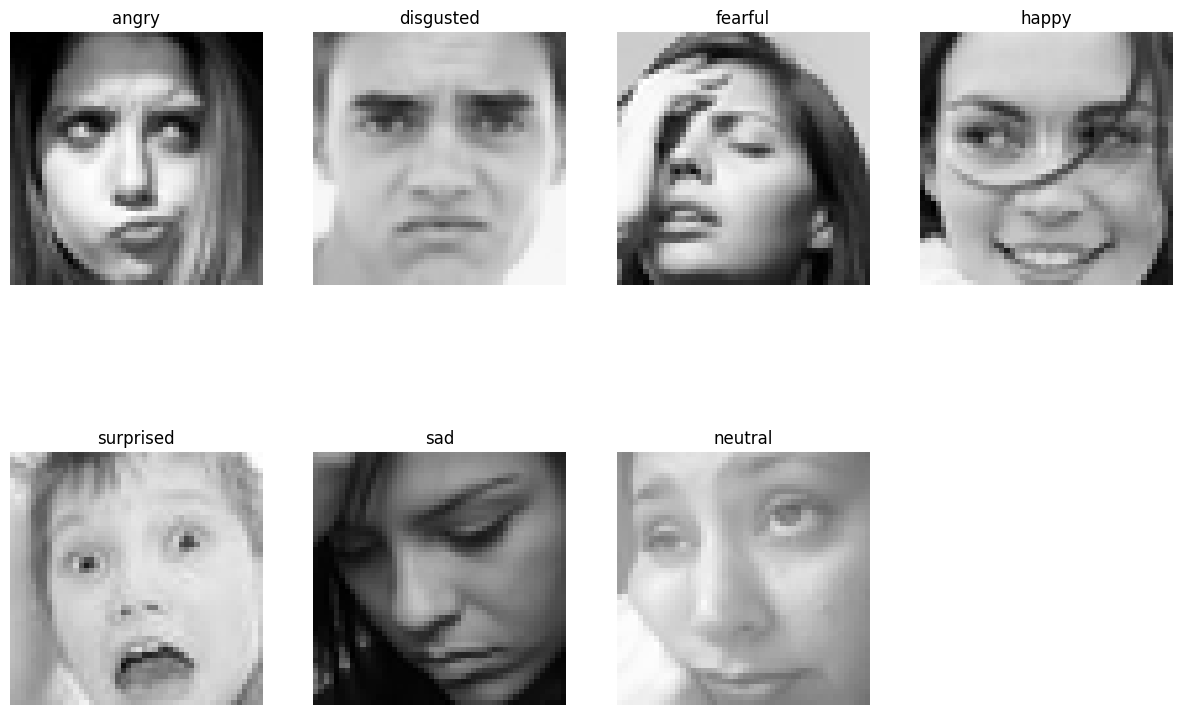

In [4]:
import matplotlib.pyplot as plt
import cv2

def show_sample_images(train_dir, categories):
    plt.figure(figsize=(15, 10))
    for i, category in enumerate(categories):
        category_path = os.path.join(train_dir, category)
        image_path = os.path.join(category_path, os.listdir(category_path)[0])
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 4, i+1)
        plt.imshow(img)
        plt.title(category)
        plt.axis('off')
    plt.show()

show_sample_images(train_dir, train_categories)


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random

In [7]:
# Image size and batch size parameters
image_size = (48, 48)  # Resize the images to 48x48
batch_size = 32

# Custom data augmentation function to add random noise
def add_noise(image):
    noise_factor = 0.1
    noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0., 1.)  # Keep pixel values within [0, 1] range
    return noisy_image


In [8]:
# Data Augmentation for the training set with additional techniques
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=add_noise  # Inject noise as a custom augmentation
)

In [9]:
# Data Augmentation for the training set with additional techniques
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=add_noise  # Inject noise as a custom augmentation
)

# Only rescaling for the test set
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for loading images from the directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Multiple classes for emotion detection
    color_mode='grayscale'  # Grayscale images for emotion detection
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)


Found 28789 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## CNN

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization

In [10]:
# Build the CNN model
model = models.Sequential()

# 1st Convolutional Layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# 2nd Convolutional Layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# 3rd Convolutional Layer
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flattening Layer
model.add(layers.Flatten())

# Fully Connected Layer 1
model.add(layers.Dense(512, activation='relu'))

# Dropout Layer
model.add(layers.Dropout(0.5))

# Fully Connected Layer 2
model.add(layers.Dense(256, activation='relu'))

# Output Layer with Softmax activation
model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,274,887 (4.86 MB)

 Trainable params: 1,274,887 (4.86 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    steps_per_epoch=train_generator.samples // batch_size
)

Epoch 1/10
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your PyDataset class should call super().__init__(**kwargs) in its constructor. **kwargs can include workers, use_multiprocessing, max_queue_size. Do not pass these arguments to fit(), as they will be ignored.
self._warn_if_super_not_called()
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.6604 - loss: 0.2340 - val_accuracy: 0.5647 - val_loss: 1.3462
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.7881 - loss: 0.1245 - val_accuracy: 0.6243 - val_loss: 1.2435
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.7976 - loss: 0.1199 - val_accuracy: 0.6542 - val_loss: 1.5432
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.8202 - loss: 0.1121 - val_accuracy: 0.6435 - val_loss: 1.0689
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.8405 - loss: 0.1095 - val_accuracy: 0.6143 - val_loss: 1

In [21]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")


Step: 224/224 ━━━━━━━━━━━━━━━━━22s 23ms/step Accuracy: 0.8988 ━ Loss: 0.6501
Test accuracy: 0.8989
Test loss: 0.6501


In [22]:
# Save the model
model.save('/content/drive/MyDrive/emotion_detection_model.h5')